# Single-Subject TMS Pulse Visualization on MRI-Based Brain Model: A Precise Method for Mapping TMS Pulses on Cortical Surface




<div class="alert alert-block alert-info">
<b>Authors:</b> 

Nikolay Syrov 1, Alfiia Mustafina 3, Artemiy Berkmush-Antipova 2, Lev Yakovlev 1,2, Andrey Demchinsky 4, Daria Petrova 1, Alexander Kaplan 1,2,5</div>


<div class="alert alert-block alert-info">
<b>Affiliations:</b> 
    
    
1. Vladimir Zelman Center for Neurobiology and Brain Rehabilitation, Skolkovo Institute of Science and Technology, Moscow, Russia
2. Baltic Center Neurotechnology and Artificial Intelligence, Immanuel Kant Baltic Federal University, Kaliningrad, Russia
3. Department of Invertebrate Zoology, Faculty of Biology, Lomonosov Moscow State University, Moscow, Russia
4. ANO Laboratory Sensor-Tech
5. Department of Human and Animal Physiology, Faculty of Biology, Lomonosov Moscow State University, Moscow, Russia
</div>





### 1. Importing necessary libraries

In [ ]:
import bpy
import csv
import numpy as np
from mathutils.bvhtree import BVHTree


### 2. Removing unwanted objects and materials from the Blender scene

In [ ]:
for o in bpy.data.objects:
    if 'Sphere' in o.name or 'pulse' in o.name or 'VECTOR' in o.name:
        bpy.data.objects.remove(o)
        
for m in bpy.data.materials:
    bpy.data.materials.remove(m)

### 3. Path to CSV files


In [ ]:
pos_path = r"\_pos.csv" 
rot_path = r"\_rot.csv" 
color_X_path = r"\_color.csv"

positions = np.loadtxt(pos_path, delimiter=',')
rotations = np.loadtxt(rot_path, delimiter=',')
colorX = np.loadtxt(color_X_path, delimiter=',')

### 4. Fiducial points

In [ ]:
NAZION = [116.0,0,0]
L_EAR = [0,79.6,0]
R_EAR = [0,-73.6,0]
COMISS1 = [-1.7, -0.6, 55.5]
COMISS2 = [29.9, -2.3, 45.7]

fiducials = [NAZION, L_EAR, R_EAR, COMISS1, COMISS2]

### 5. Creare list of polygons for the Brain model.

In [ ]:
brain_mesh =  bpy.data.objects['Your Brain Model']
brain_matrix_world = brain_mesh.matrix_world.copy()
brain_mesh_verts = [brain_matrix_world @ vertex.co for vertex in brain_mesh.data.vertices]
brain_mesh_polys = [polygon.vertices for polygon in brain_mesh.data.polygons]


MESHES_PULSE = []

The third line retrieves the local coordinates of each vertex in the brain model and transforms them into world coordinates using the copied transformation matrix.

The fourth line retrieves the indices of the vertices that make up each polygon in the brain model. These indices are used to construct the polygons of the mesh.

The resulting **brain_mesh_verts** and **brain_mesh_polys** can be used to create a **BVHTree object**, which is useful for detecting intersections with other objects in the scene.

### 6. Fuction for creation of  vectors aligned with the coil orientation 

In [ ]:
def create_TMS_vector(pos, rot, TMS_pulse_name):
    # Extract position and orientation information from the input parameters
    indx, x, y, z = pos[0], pos[1], pos[2], pos[3]  # coil position coordinates
    _, ax, ay, az, aw = rot[0], rot[1], rot[2], rot[3], rot[4]  # coil orientation (in quaternions)

    # Print out the position and orientation information for debugging purposes
    print(indx)
    print('POSITION', x, y, z)
    print('QUATERNION', ax, ay, az, aw)

    # Add a magnetic field gradient vector as a cube object
    bpy.ops.mesh.primitive_cube_add(scale=(0.5, 0.5, 50))

    # Change the rotation mode of the object from Euler to Quaternion
    bpy.context.object.rotation_mode = 'QUATERNION'

    # Rename the active object to the given TMS pulse name
    bpy.context.active_object.name = TMS_pulse_name

    # Move the object to the specified position
    bpy.ops.transform.translate(value=(x, y, z), orient_axis_ortho='X')

    # Create a new material for the object and set its diffuse color to blue
    material = bpy.data.materials.new('material')
    material.diffuse_color = (0, 0, 1, 1)
    bpy.context.object.data.materials.append(material)

    # Resize the object and set its rotation to the specified quaternion
    bpy.ops.transform.resize(value=(1, 1, 1))
    bpy.context.object.rotation_quaternion[0] = aw
    bpy.context.object.rotation_quaternion[1] = ax
    bpy.context.object.rotation_quaternion[2] = ay
    bpy.context.object.rotation_quaternion[3] = az

    # Get a reference to the TMS pulse mesh object and return it
    Tms_pulse_mesh = bpy.data.objects[TMS_pulse_name]
    return Tms_pulse_mesh 

The **create_TMS_vector** function takes in three parameters:

**pos**: A list containing the position information of the TMS coil, including the index and x, y, and z coordinates.
**rot**: A list containing the orientation information of the TMS coil, including the quaternion values for the x, y, z, and w components.
**TMS_pulse_name**: A string representing the name of the TMS pulse object to be created.

The function first extracts the position and orientation information from the input parameters and prints them out for debugging purposes. 
It then adds a cube object as a magnetic field gradient vector and changes its rotation mode to **Quaternion**.

The object is then renamed to the given TMS pulse name and moved to the specified position. 
A new material is created for the object, and its diffuse color is set to blue.

The object is then resized and rotated to the specified quaternion. 
Finally, a reference to the TMS pulse mesh object is obtained, and it is returned.


### 7. Fiducials generation

***P A R T 1:***  run this loop first to create  fiducials

In [ ]:
for fid in fiducials:
    create_fiducials(fid)

### 8. Iterate over the positions, rotations, and color codes of brain regions


#### P A R T 2 : run the code below after brain model position adjustment 

In [ ]:
for p, r, ccx in zip(positions,rotations, colorX):
    
    id = p[0]
    
    # create a unique name for the TMS pulse vector
    pulse_name = f'VECTOR.{id}'
    
    # create a TMS pulse gradient vector mesh
    mesh_2 = create_TMS_vector(p, r, pulse_name) #spawn TMS pulse gradient vector

    # extract the color code from the tuple
    _, cx = ccx[0], ccx[1] # take pulse color code
    print(cx)
    
    # create an RGBA color tuple based on the color code (from 0 to 1)
    colors = (0,1-cx,cx, 1) 
    
    # create a unique name for the cortical point mesh
    pulse_name_sphere = f'pulse.{id}' # create name for future cortical point

    # add the TMS pulse vector mesh, the cortical point mesh name, 
    # and the colors to the MESHES_PULSE list
    MESHES_PULSE.append([mesh_2, pulse_name_sphere, colors])

**The code above creates TMS pulse gradient vector meshes** based on the positions, rotations. 

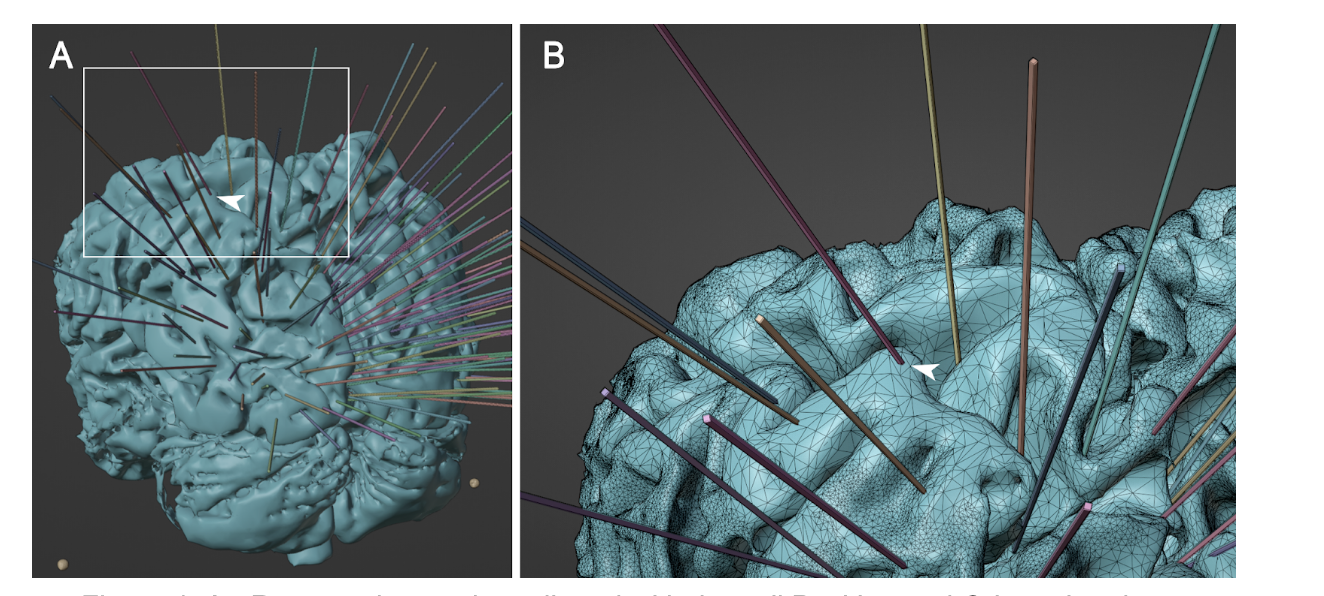

***A - Rectangular meshes aligned with the coil Position and Orientation data, intersecting the cortical surface of the Brain Model.*** 

***B - Close view: cursor pointing intersected cortical polygons.***

### 9. Find the intersections between the brain and the each TMS pulse vector

Search for the intersection of Mesh_1 (brain model) and Mesh_2 (specific TMS vector). 

In [ ]:

for pulse_mesh in MESHES_PULSE:
    
    # extract the TMS pulse vector mesh, pulse name, and color code from the list
    tms_mesh = pulse_mesh[0] # reminder: "j" contains 3 elements: 0 - TMS_vector_mesh, 1 - pulse_name, 2 - color_code
    pulse_name = pulse_mesh[1]
    color_i = pulse_mesh[2]
    
    # create a copy of the world matrix for the TMS pulse vector mesh
    tms_matrix_world = tms_mesh.matrix_world.copy()

    # transform the TMS pulse vector mesh vertices into global coordinates
    tms_mesh_verts = [tms_matrix_world @ vertex.co for vertex in tms_mesh.data.vertices] 

    # get the polygons (faces) of the TMS pulse vector mesh
    tms_mesh_polys = [polygon.vertices for polygon in tms_mesh.data.polygons]

    
    
    # create BVH trees for the brain mesh and the TMS pulse vector mesh
    brain_bvh_tree = BVHTree.FromPolygons(brain_mesh_verts, brain_mesh_polys)
    tms_bvh_tree = BVHTree.FromPolygons(tms_mesh_verts, tms_mesh_polys)

    
    # find the intersections between the brain mesh and the TMS pulse vector mesh
    intersections = brain_bvh_tree.overlap(tms_bvh_tree)

    # create a list of the indices of the intersecting polygons in the brain mesh
    brain_mesh_polys_ints = [pair[0] for pair in intersections]
    
    # create a list of all the faces in the brain mesh
    brain_faces = [face for face in brain_mesh.data.polygons]
    brain_face_indices = np.array([face.index for face in brain_mesh.data.polygons])

    try:
        # create an empty list to store the sums of the absolute values 
        # of the coordinates of the intersecting polygons
        SUMM_list = []
        
        # iterate over the indices of the intersecting polygons in the brain mesh
        for ix in brain_mesh_polys_ints:
            Which_ix = np.where(brain_face_indices == ix)[0][0]
            ThatFace_ix = brain_faces[Which_ix]
            ThatFace_ix.select = True
            xx_i,yy_i,zz_i =  ThatFace_ix.center
            SUMM = np.sum(np.abs(np.array([xx_i,yy_i,zz_i])))
            SUMM_list.append(SUMM)
            
        # find the index of the polygon with the highest sum of the absolute values of its coordinates
        MaxiCoor = np.argmax(SUMM_list)
        print('M A X:::', MaxiCoor)
        ########################################
        print('zerocross=', brain_mesh_polys_ints[MaxiCoor])
        
        # find the index of the polygon in the brain_face_indices array
        Which = np.where(brain_face_indices == brain_mesh_polys_ints[MaxiCoor])[0][0]
        print('Which:', Which)
        
        ThatFace = brain_faces[Which]
        ThatFace.select = True
        xx,yy,zz =  ThatFace.center + brain_mesh.location
        
        #create sphere marker indicating cortical point afferced by TMS
        bpy.ops.mesh.primitive_uv_sphere_add(enter_editmode=False, 
                            align='WORLD', location=(xx, yy, zz), scale=(2, 2, 2))
        bpy.context.active_object.name = pulse_name
        
        # make a specific colour for cortical marker
        tms_mat = bpy.data.materials.new('material')
        tms_mat.diffuse_color = color_i
        bpy.context.object.data.materials.append(tms_mat)
        print('Color - created')
        
    except:
        print('no intersections')

This part of the script is responsible for removing all objects from the Blender scene that have the word "VECTOR" in their name (TMS vectors) 
The bpy.data.objects method retrieves a collection of all the objects in the current Blender scene.

In [ ]:
for o in bpy.data.objects:
    if 'VECTOR' in o.name :
        bpy.data.objects.remove(o)

        
print('Done')

### The resulting scene 

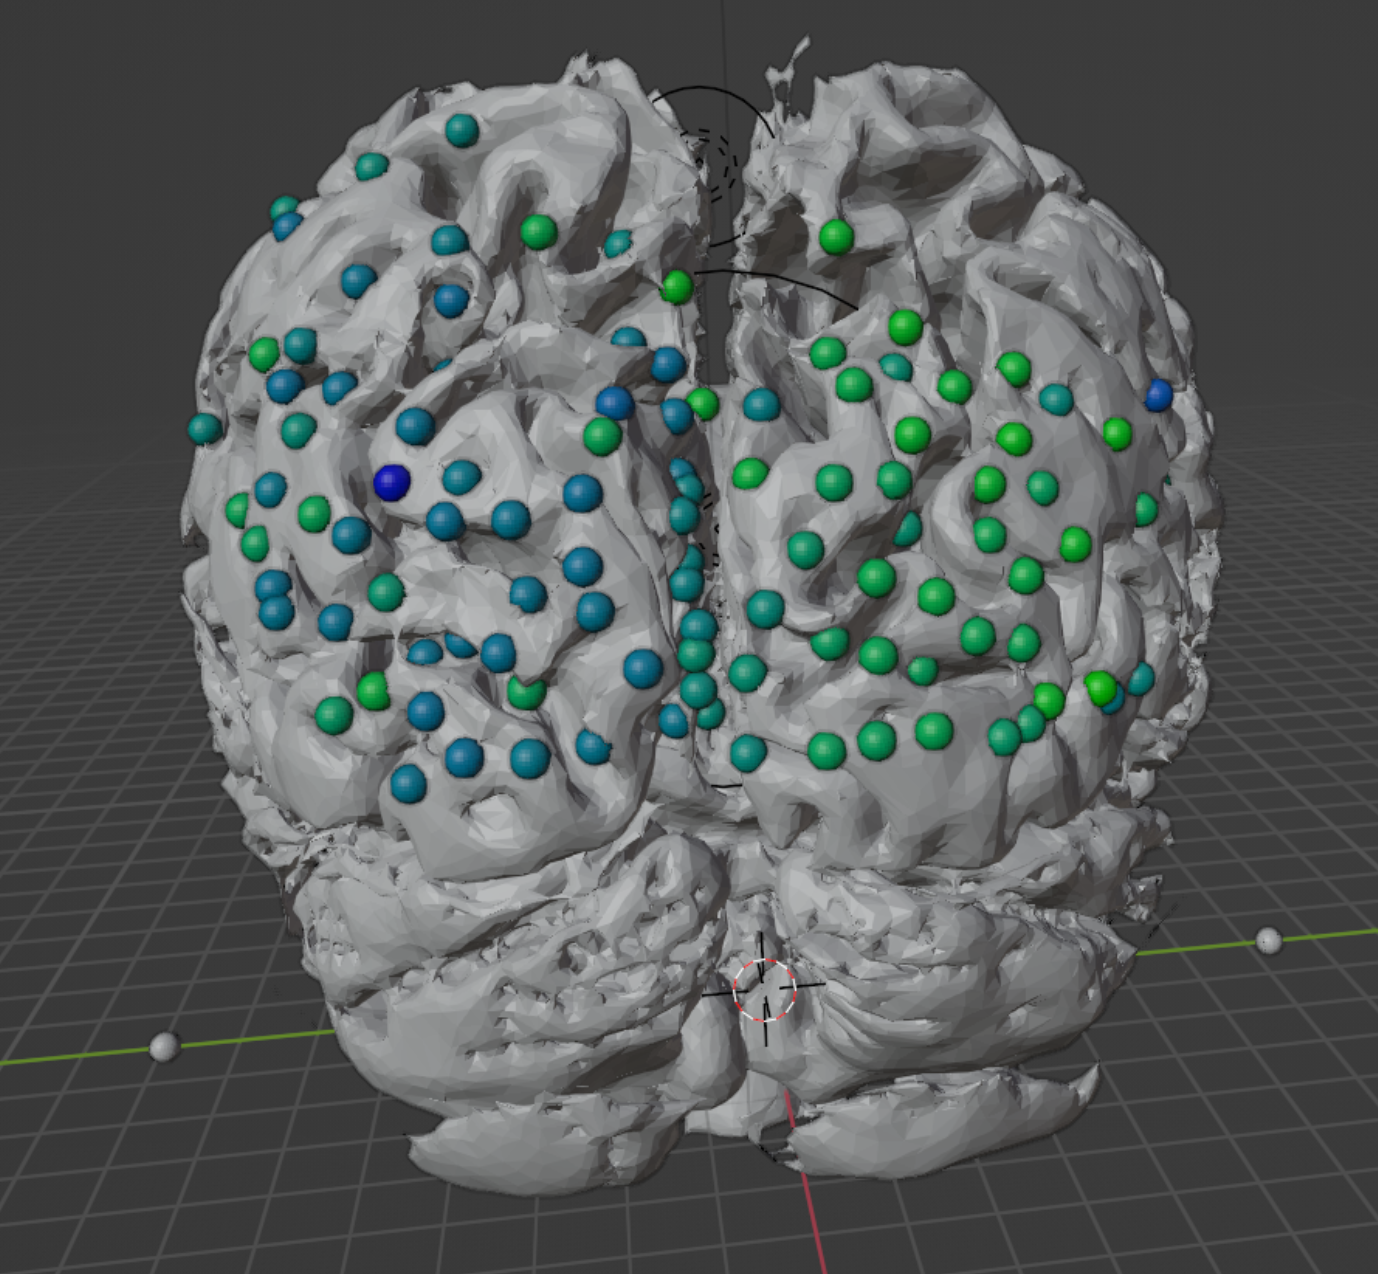